In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


In [ ]:
print(torch.__version__)
print("cuda available:", torch.cuda.is_available())
print("device count:", torch.cuda.device_count())

Using device: cuda
Model load time: 0.54s
Loaded 997 articles in 0.02s
Sentiment analysis time: 36.71s
Price fetch time: 0.21s


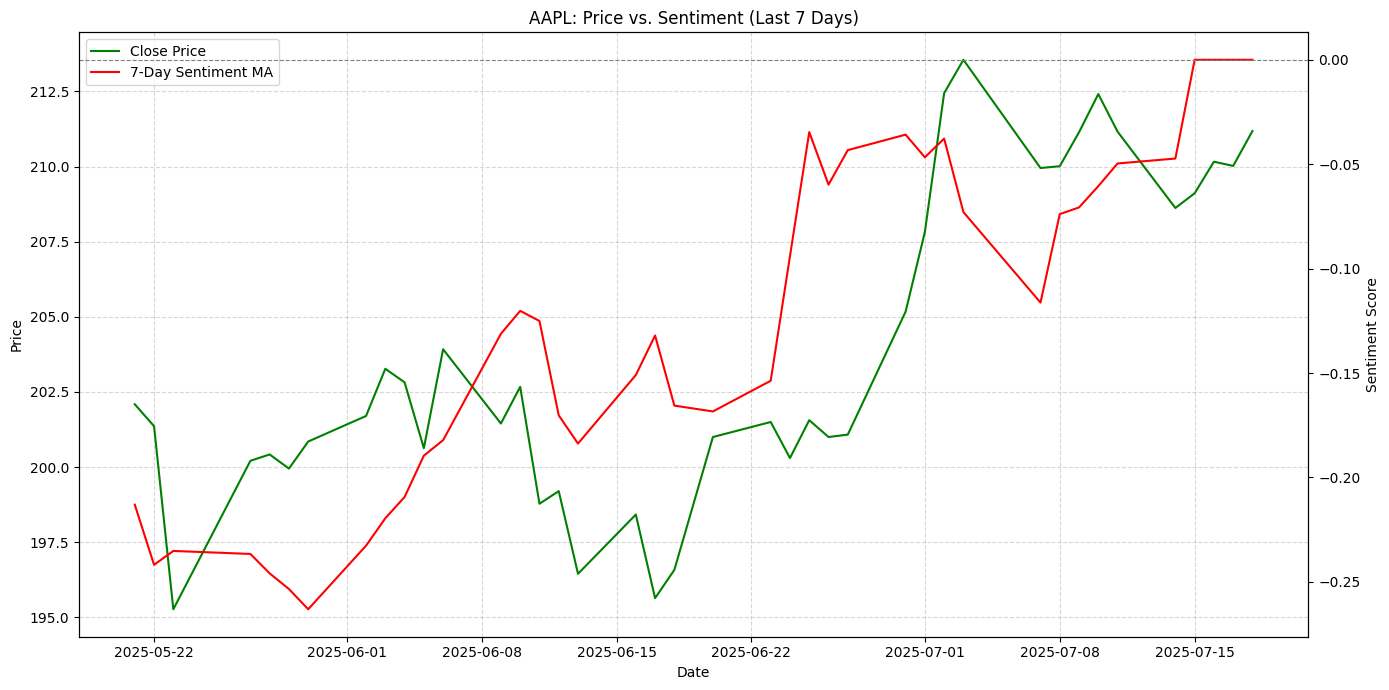

In [11]:
# visualize_sentiment.py

import os
import sys
import time
from pathlib import Path

import pandas as pd
import torch
import requests
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# ─── resolve script_dir ───────────────────────────────────────────────────────
try:
    script_dir = Path(__file__).parent
except NameError:
    script_dir = Path.cwd()

proj_root = script_dir.parent
if str(proj_root) not in sys.path:
    sys.path.insert(0, str(proj_root))

# ─── CONFIG ───────────────────────────────────────────────────────────────────
API_KEY    = os.getenv("FMP_API_KEY")  # your FMP key
MODEL_PATH = script_dir / "finbert-finetuned-final"
ART_DIR    = script_dir / "articles"
CHUNK_SIZE = 32     # adjust down (e.g. 16 or 8) if you still get OOM

# ─── HELPERS ──────────────────────────────────────────────────────────────────

def load_articles(ticker: str) -> pd.DataFrame:
    path = ART_DIR / f"{ticker}.csv"
    df = pd.read_csv(path, parse_dates=["publishedDate"])
    df["date"] = df["publishedDate"].dt.date
    return df

def analyze_sentiment_chunked(
    df: pd.DataFrame,
    tokenizer,
    model,
    device: torch.device,
    chunk_size: int
) -> pd.DataFrame:
    """
    Tokenize texts in chunks and run each chunk through the model on `device`.
    Sentiment score = positive_prob − negative_prob.
    """
    texts = (df["content"].fillna("") + " " + df["title"].fillna("")).tolist()
    dates = pd.to_datetime(df["date"]).tolist()
    records = []

    for i in range(0, len(texts), chunk_size):
        batch_texts = texts[i : i + chunk_size]
        batch_dates = dates[i : i + chunk_size]

        inputs = tokenizer(
            batch_texts,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=512
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            logits = model(**inputs).logits

        probs = torch.softmax(logits, dim=1).cpu().numpy()
        scores = probs[:, 0] - probs[:, 2]

        for d, s in zip(batch_dates, scores):
            records.append({"date": d, "sentiment": float(s)})

        # free GPU memory between chunks
        del inputs, logits, probs
        if device.type == "cuda":
            torch.cuda.empty_cache()

    return pd.DataFrame(records)

def fetch_last_7_days(ticker: str) -> pd.DataFrame:
    url = (
        f"https://financialmodelingprep.com/api/v3/"
        f"historical-price-full/{ticker}"
        f"?timeseries=40&apikey={API_KEY}"
    )
    resp = requests.get(url)
    resp.raise_for_status()
    json_resp = resp.json()
    recs = json_resp.get("historical", []) if isinstance(json_resp, dict) else []
    df = pd.DataFrame(recs)
    df["date"] = pd.to_datetime(df["date"])
    return df[["date", "close"]]

# ─── MAIN ─────────────────────────────────────────────────────────────────────

def main(ticker: str):
    # choose device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # load model & tokenizer
    t0 = time.perf_counter()
    tokenizer = AutoTokenizer.from_pretrained(str(MODEL_PATH))
    model = AutoModelForSequenceClassification.from_pretrained(
        str(MODEL_PATH),
        torch_dtype=(torch.float16 if device.type == "cuda" else torch.float32)
    )
    model.to(device).eval()
    print(f"Model load time: {time.perf_counter() - t0:.2f}s")

    # load articles
    t1 = time.perf_counter()
    art_df = load_articles(ticker)
    print(f"Loaded {len(art_df)} articles in {time.perf_counter() - t1:.2f}s")
    if art_df.empty:
        print(f"No articles found for {ticker}.")
        return

    # sentiment analysis in chunks
    t2 = time.perf_counter()
    sent_df = analyze_sentiment_chunked(art_df, tokenizer, model, device, CHUNK_SIZE)
    print(f"Sentiment analysis time: {time.perf_counter() - t2:.2f}s")

    # daily aggregation
    daily = sent_df.groupby("date", as_index=False)["sentiment"].mean()
    daily["date"] = pd.to_datetime(daily["date"])

    # fetch last 7 days of prices
    t3 = time.perf_counter()
    price_df = fetch_last_7_days(ticker)
    print(f"Price fetch time: {time.perf_counter() - t3:.2f}s")

    # merge & fill
    merged = price_df.merge(daily, on="date", how="left")
    merged["sentiment"] = merged["sentiment"].fillna(0.0)
    merged["sentiment_ma"] = merged["sentiment"].rolling(7, min_periods=1).mean()

    # plot with green price / red sentiment
    fig, ax1 = plt.subplots(figsize=(14, 7))
    ax1.plot(merged["date"], merged["close"], label="Close Price", color="green")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Price")
    ax1.grid(True, linestyle="--", alpha=0.5)

    ax2 = ax1.twinx()
    ax2.plot(
        merged["date"],
        merged["sentiment_ma"],
        label="7-Day Sentiment MA",
        color="red"
    )
    ax2.set_ylabel("Sentiment Score")
    ax2.axhline(0, linestyle="--", linewidth=0.8, color="gray")

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc="upper left")

    plt.title(f"{ticker}: Price vs. Sentiment (Last 7 Days)")
    plt.tight_layout()
    plt.show()

# ─── ENTRY POINT ──────────────────────────────────────────────────────────────

if __name__ == "__main__":
    ticker = input("Enter ticker (e.g. AAPL): ").strip().upper()
    main(ticker)


Using device: cuda
Model load time: 0.43s
Loaded 997 articles in 0.02s
Sentiment analysis time: 37.24s
Price fetch time: 0.22s


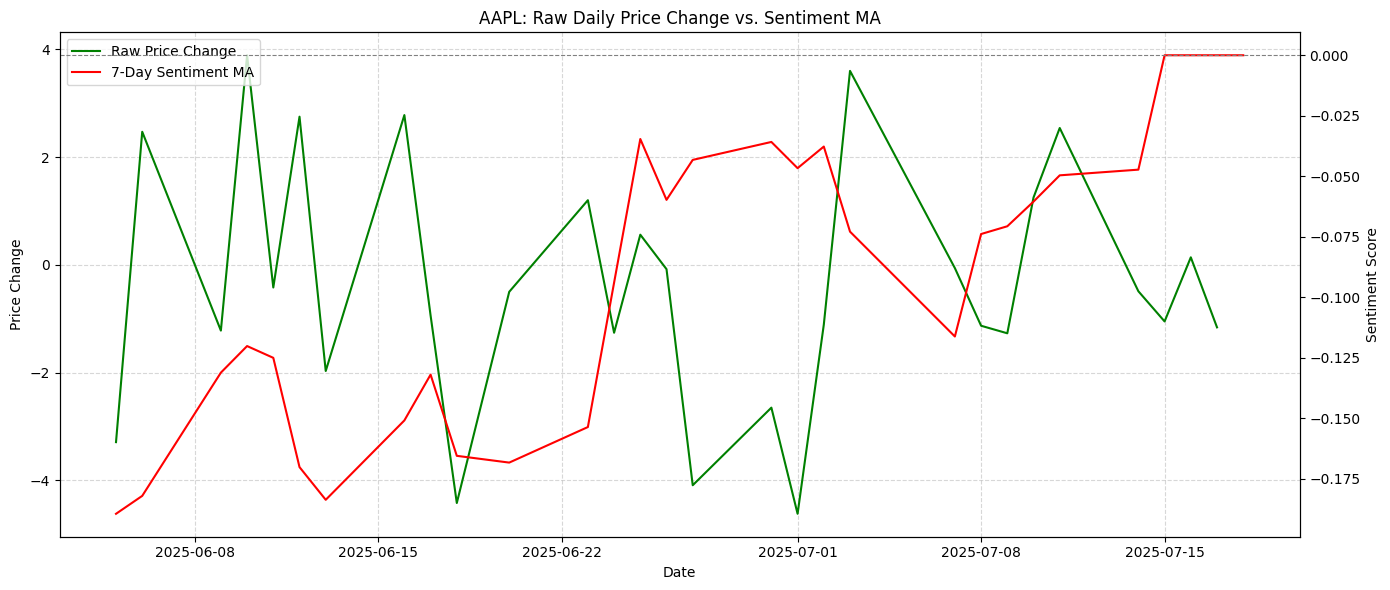

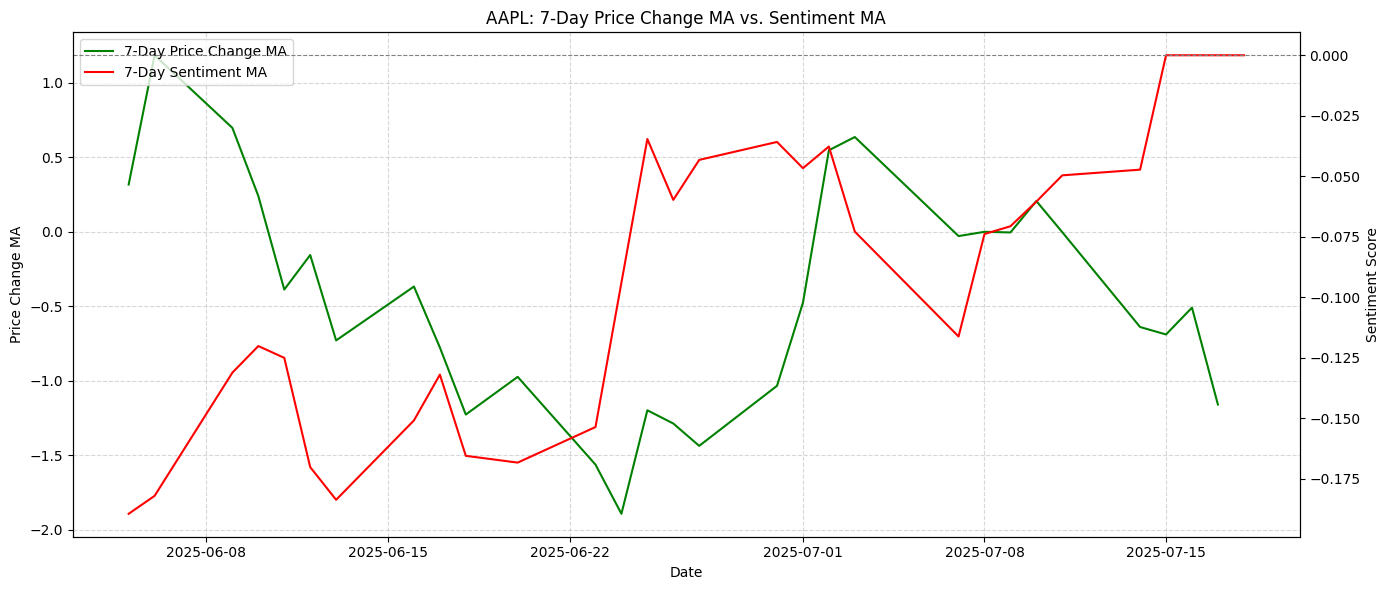

In [13]:
# visualize_sentiment.py

import os
import sys
import time
from pathlib import Path

import pandas as pd
import torch
import requests
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# ─── resolve script_dir ───────────────────────────────────────────────────────
try:
    script_dir = Path(__file__).parent
except NameError:
    script_dir = Path.cwd()

proj_root = script_dir.parent
if str(proj_root) not in sys.path:
    sys.path.insert(0, str(proj_root))

# ─── CONFIG ───────────────────────────────────────────────────────────────────
API_KEY    = os.getenv("FMP_API_KEY") # your FMP key
MODEL_PATH = script_dir / "finbert-finetuned-final"
ART_DIR    = script_dir / "articles"
CHUNK_SIZE = 32     # adjust down if you still get OOM

# ─── HELPERS ──────────────────────────────────────────────────────────────────

def load_articles(ticker: str) -> pd.DataFrame:
    path = ART_DIR / f"{ticker}.csv"
    df = pd.read_csv(path, parse_dates=["publishedDate"])
    df["date"] = df["publishedDate"].dt.date
    return df

def analyze_sentiment_chunked(
    df: pd.DataFrame,
    tokenizer,
    model,
    device: torch.device,
    chunk_size: int
) -> pd.DataFrame:
    texts = (df["content"].fillna("") + " " + df["title"].fillna("")).tolist()
    dates = pd.to_datetime(df["date"]).tolist()
    records = []

    for i in range(0, len(texts), chunk_size):
        batch_texts = texts[i : i + chunk_size]
        batch_dates = dates[i : i + chunk_size]

        inputs = tokenizer(
            batch_texts,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=512
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            logits = model(**inputs).logits

        probs = torch.softmax(logits, dim=1).cpu().numpy()
        scores = probs[:, 0] - probs[:, 2]

        for d, s in zip(batch_dates, scores):
            records.append({"date": d, "sentiment": float(s)})

        del inputs, logits, probs
        if device.type == "cuda":
            torch.cuda.empty_cache()

    return pd.DataFrame(records)

def fetch_last_7_days(ticker: str) -> pd.DataFrame:
    url = (
        f"https://financialmodelingprep.com/api/v3/"
        f"historical-price-full/{ticker}"
        f"?timeseries=30&apikey={API_KEY}"
    )
    resp = requests.get(url); resp.raise_for_status()
    json_resp = resp.json()
    recs = json_resp.get("historical", []) if isinstance(json_resp, dict) else []
    df = pd.DataFrame(recs)
    df["date"] = pd.to_datetime(df["date"])
    return df[["date", "close"]]

# ─── MAIN ─────────────────────────────────────────────────────────────────────

def main(ticker: str):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # 1. Load model & tokenizer
    t0 = time.perf_counter()
    tokenizer = AutoTokenizer.from_pretrained(str(MODEL_PATH))
    model = AutoModelForSequenceClassification.from_pretrained(
        str(MODEL_PATH),
        torch_dtype=(torch.float16 if device.type == "cuda" else torch.float32)
    )
    model.to(device).eval()
    print(f"Model load time: {time.perf_counter() - t0:.2f}s")

    # 2. Load articles
    t1 = time.perf_counter()
    art_df = load_articles(ticker)
    print(f"Loaded {len(art_df)} articles in {time.perf_counter() - t1:.2f}s")
    if art_df.empty:
        print(f"No articles found for {ticker}.")
        return

    # 3. Analyze sentiment in chunks
    t2 = time.perf_counter()
    sent_df = analyze_sentiment_chunked(art_df, tokenizer, model, device, CHUNK_SIZE)
    print(f"Sentiment analysis time: {time.perf_counter() - t2:.2f}s")

    # 4. Aggregate daily sentiment
    daily = sent_df.groupby("date", as_index=False)["sentiment"].mean()
    daily["date"] = pd.to_datetime(daily["date"])

    # 5. Fetch last 7 days of prices
    t3 = time.perf_counter()
    price_df = fetch_last_7_days(ticker)
    print(f"Price fetch time: {time.perf_counter() - t3:.2f}s")

    # 6. Merge and compute price-change series
    merged = price_df.merge(daily, on="date", how="left")
    merged["sentiment"] = merged["sentiment"].fillna(0.0)

    # raw differenced series
    merged["price_diff"] = merged["close"].diff()

    # 7-day rolling mean of price_diff
    merged["price_diff_ma"] = merged["price_diff"].rolling(7, min_periods=1).mean()

    # 7-day rolling mean of sentiment (already computed previously)
    merged["sentiment_ma"] = merged["sentiment"].rolling(7, min_periods=1).mean()

    dates = merged["date"]

    # ─── PLOT 1: raw price change vs. sentiment MA ───────────────────────────────
    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax1.plot(dates, merged["price_diff"], label="Raw Price Change", color="green")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Price Change")
    ax1.grid(True, linestyle="--", alpha=0.5)

    ax2 = ax1.twinx()
    ax2.plot(dates, merged["sentiment_ma"], label="7‑Day Sentiment MA", color="red")
    ax2.set_ylabel("Sentiment Score")
    ax2.axhline(0, linestyle="--", linewidth=0.8, color="gray")

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc="upper left")
    plt.title(f"{ticker}: Raw Daily Price Change vs. Sentiment MA")
    plt.tight_layout()
    plt.show()

    # ─── PLOT 2: 7-day MA of price change vs. sentiment MA ───────────────────────
    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax1.plot(dates, merged["price_diff_ma"], label="7‑Day Price Change MA", color="green")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Price Change MA")
    ax1.grid(True, linestyle="--", alpha=0.5)

    ax2 = ax1.twinx()
    ax2.plot(dates, merged["sentiment_ma"], label="7‑Day Sentiment MA", color="red")
    ax2.set_ylabel("Sentiment Score")
    ax2.axhline(0, linestyle="--", linewidth=0.8, color="gray")

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc="upper left")
    plt.title(f"{ticker}: 7‑Day Price Change MA vs. Sentiment MA")
    plt.tight_layout()
    plt.show()

# ─── ENTRY POINT ──────────────────────────────────────────────────────────────

if __name__ == "__main__":
    ticker = input("Enter ticker (e.g. AAPL): ").strip().upper()
    main(ticker)


Using device: cuda
Model load time: 1.17s
Loaded 996 articles in 0.08s
Sentiment analysis time: 55.35s
Price fetch time: 0.22s


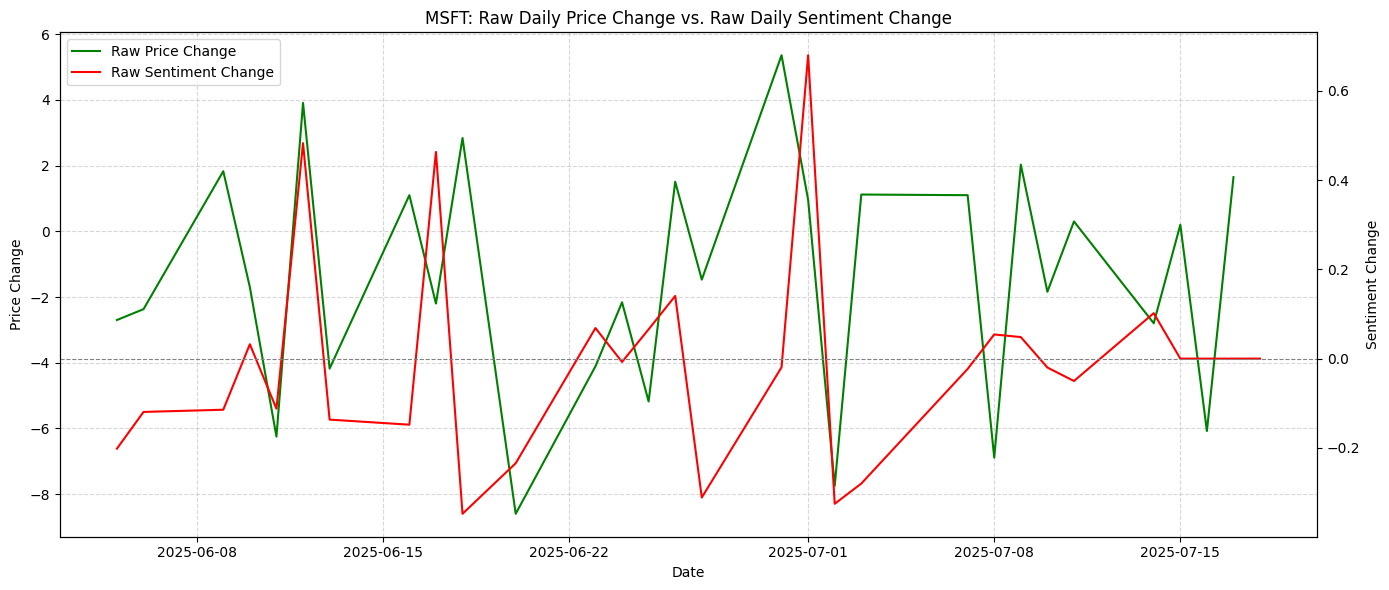

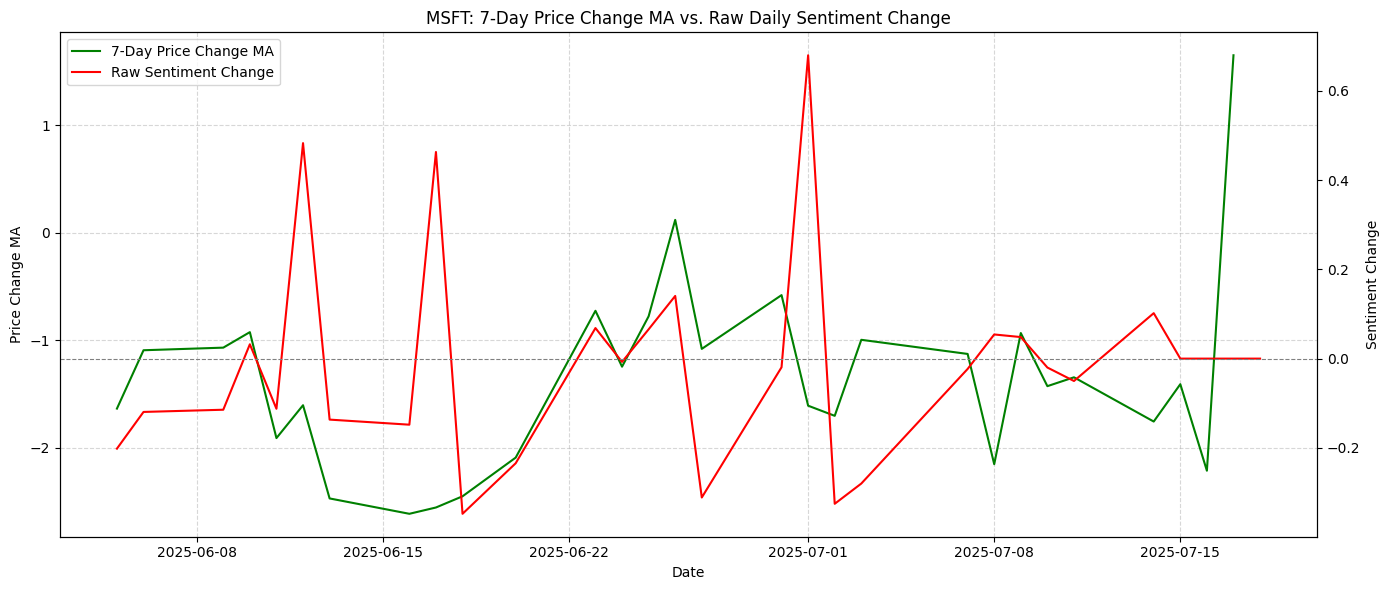

In [15]:
# visualize_sentiment.py

import os
import sys
import time
from pathlib import Path

import pandas as pd
import torch
import requests
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# ─── resolve script_dir ───────────────────────────────────────────────────────
try:
    script_dir = Path(__file__).parent
except NameError:
    script_dir = Path.cwd()

proj_root = script_dir.parent
if str(proj_root) not in sys.path:
    sys.path.insert(0, str(proj_root))

# ─── CONFIG ───────────────────────────────────────────────────────────────────
API_KEY    =  os.getenv("FMP_API_KEY")   # your FMP key
MODEL_PATH = script_dir / "finbert-finetuned-final"
ART_DIR    = script_dir / "articles"
CHUNK_SIZE = 32     # adjust down if you still hit OOM on GPU

# ─── HELPERS ──────────────────────────────────────────────────────────────────

def load_articles(ticker: str) -> pd.DataFrame:
    path = ART_DIR / f"{ticker}.csv"
    df = pd.read_csv(path, parse_dates=["publishedDate"])
    df["date"] = df["publishedDate"].dt.date
    return df

def analyze_sentiment_chunked(
    df: pd.DataFrame,
    tokenizer,
    model,
    device: torch.device,
    chunk_size: int
) -> pd.DataFrame:
    texts = (df["content"].fillna("") + " " + df["title"].fillna("")).tolist()
    dates = pd.to_datetime(df["date"]).tolist()
    records = []

    for i in range(0, len(texts), chunk_size):
        batch_texts = texts[i : i + chunk_size]
        batch_dates = dates[i : i + chunk_size]

        inputs = tokenizer(
            batch_texts,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=512
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            logits = model(**inputs).logits

        probs = torch.softmax(logits, dim=1).cpu().numpy()
        scores = probs[:, 0] - probs[:, 2]

        for d, s in zip(batch_dates, scores):
            records.append({"date": d, "sentiment": float(s)})

        del inputs, logits, probs
        if device.type == "cuda":
            torch.cuda.empty_cache()

    return pd.DataFrame(records)

def fetch_last_7_days(ticker: str) -> pd.DataFrame:
    url = (
        f"https://financialmodelingprep.com/api/v3/"
        f"historical-price-full/{ticker}"
        f"?timeseries=30&apikey={API_KEY}"
    )
    resp = requests.get(url); resp.raise_for_status()
    json_resp = resp.json()
    recs = json_resp.get("historical", []) if isinstance(json_resp, dict) else []
    df = pd.DataFrame(recs)
    df["date"] = pd.to_datetime(df["date"])
    return df[["date", "close"]]

# ─── MAIN ─────────────────────────────────────────────────────────────────────

def main(ticker: str):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # 1. Load model & tokenizer
    t0 = time.perf_counter()
    tokenizer = AutoTokenizer.from_pretrained(str(MODEL_PATH))
    model = AutoModelForSequenceClassification.from_pretrained(
        str(MODEL_PATH),
        torch_dtype=(torch.float16 if device.type == "cuda" else torch.float32)
    )
    model.to(device).eval()
    print(f"Model load time: {time.perf_counter() - t0:.2f}s")

    # 2. Load articles
    t1 = time.perf_counter()
    art_df = load_articles(ticker)
    print(f"Loaded {len(art_df)} articles in {time.perf_counter() - t1:.2f}s")
    if art_df.empty:
        print(f"No articles found for {ticker}.")
        return

    # 3. Analyze sentiment in chunks
    t2 = time.perf_counter()
    sent_df = analyze_sentiment_chunked(art_df, tokenizer, model, device, CHUNK_SIZE)
    print(f"Sentiment analysis time: {time.perf_counter() - t2:.2f}s")

    # 4. Aggregate daily sentiment
    daily = sent_df.groupby("date", as_index=False)["sentiment"].mean()
    daily["date"] = pd.to_datetime(daily["date"])

    # 5. Fetch last 7 days of prices
    t3 = time.perf_counter()
    price_df = fetch_last_7_days(ticker)
    print(f"Price fetch time: {time.perf_counter() - t3:.2f}s")

    # 6. Merge and compute changes
    merged = price_df.merge(daily, on="date", how="left")
    merged["sentiment"] = merged["sentiment"].fillna(0.0)

    # price change (ΔP) and its 7‑day rolling mean
    merged["price_diff"] = merged["close"].diff()
    merged["price_diff_ma"] = merged["price_diff"].rolling(7, min_periods=1).mean()

    # sentiment change (ΔS)
    merged["sentiment_diff"] = merged["sentiment"].diff().fillna(0.0)

    dates = merged["date"]

    # ─── PLOT 1: raw price change vs. raw sentiment change ───────────────────────
    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax1.plot(dates, merged["price_diff"], label="Raw Price Change", color="green")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Price Change")
    ax1.grid(True, linestyle="--", alpha=0.5)

    ax2 = ax1.twinx()
    ax2.plot(dates, merged["sentiment_diff"], label="Raw Sentiment Change", color="red")
    ax2.set_ylabel("Sentiment Change")
    ax2.axhline(0, linestyle="--", linewidth=0.8, color="gray")

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc="upper left")
    plt.title(f"{ticker}: Raw Daily Price Change vs. Raw Daily Sentiment Change")
    plt.tight_layout()
    plt.show()

    # ─── PLOT 2: 7‑day MA price change vs. raw sentiment change ─────────────────
    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax1.plot(dates, merged["price_diff_ma"], label="7‑Day Price Change MA", color="green")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Price Change MA")
    ax1.grid(True, linestyle="--", alpha=0.5)

    ax2 = ax1.twinx()
    ax2.plot(dates, merged["sentiment_diff"], label="Raw Sentiment Change", color="red")
    ax2.set_ylabel("Sentiment Change")
    ax2.axhline(0, linestyle="--", linewidth=0.8, color="gray")

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc="upper left")
    plt.title(f"{ticker}: 7‑Day Price Change MA vs. Raw Daily Sentiment Change")
    plt.tight_layout()
    plt.show()

# ─── ENTRY POINT ──────────────────────────────────────────────────────────────

if __name__ == "__main__":
    ticker = input("Enter ticker (e.g. AAPL): ").strip().upper()
    main(ticker)


In [ ]:
# visualize_sentiment.py

import os
import sys
import time
from pathlib import Path

import pandas as pd
import torch
import requests
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# ─── resolve script_dir ───────────────────────────────────────────────────────
try:
    script_dir = Path(__file__).parent
except NameError:
    script_dir = Path.cwd()

proj_root = script_dir.parent
if str(proj_root) not in sys.path:
    sys.path.insert(0, str(proj_root))

# ─── CONFIG ───────────────────────────────────────────────────────────────────
API_KEY    = os.getenv("FMP_API_KEY")  # your FMP key
MODEL_PATH = script_dir / "finbert-finetuned-final"
ART_DIR    = script_dir / "articles"

# ─── HELPERS ──────────────────────────────────────────────────────────────────

def load_articles(ticker: str) -> pd.DataFrame:
    path = ART_DIR / f"{ticker}.csv"
    df = pd.read_csv(path, parse_dates=["publishedDate"])
    df["date"] = df["publishedDate"].dt.date
    return df

def analyze_sentiment_batched(df: pd.DataFrame, tokenizer, model, device) -> pd.DataFrame:
    """
    Tokenize all texts in one batch and do a single forward pass on the given device.
    Sentiment = positive_prob − negative_prob.
    """
    texts = (df["content"].fillna("") + " " + df["title"].fillna("")).tolist()
    dates = pd.to_datetime(df["date"]).tolist()

    # batch-tokenize
    inputs = tokenizer(
        texts,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=512
    )

    # move inputs to device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        logits = model(**inputs).logits

    probs = torch.softmax(logits, dim=1).cpu().numpy()
    scores = probs[:, 0] - probs[:, 2]

    return pd.DataFrame({ "date": dates, "sentiment": scores })

def fetch_last_7_days(ticker: str) -> pd.DataFrame:
    url = (
        f"https://financialmodelingprep.com/api/v3/"
        f"historical-price-full/{ticker}"
        f"?timeseries=7&apikey={API_KEY}"
    )
    resp = requests.get(url)
    resp.raise_for_status()
    json_resp = resp.json()
    records = json_resp.get("historical", []) if isinstance(json_resp, dict) else []
    prices = pd.DataFrame(records)
    prices["date"] = pd.to_datetime(prices["date"])
    return prices[["date", "close"]]

# ─── MAIN ─────────────────────────────────────────────────────────────────────

def main(ticker: str):
    # pick GPU if you have one
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # 1. Load model & tokenizer
    t0 = time.perf_counter()
    tokenizer = AutoTokenizer.from_pretrained(str(MODEL_PATH))
    model     = AutoModelForSequenceClassification.from_pretrained(str(MODEL_PATH))
    model.to(device)
    model.eval()
    print(f"Model load time: {time.perf_counter() - t0:.2f}s")

    # 2. Load articles
    t1 = time.perf_counter()
    art_df = load_articles(ticker)
    print(f"Loaded {len(art_df)} articles in {time.perf_counter() - t1:.2f}s")

    if art_df.empty:
        print(f"No articles found for {ticker}.")
        return

    # 3. Analyze sentiment (batched on GPU)
    t2 = time.perf_counter()
    sent_df = analyze_sentiment_batched(art_df, tokenizer, model, device)
    print(f"Sentiment analysis time: {time.perf_counter() - t2:.2f}s")

    # 4. Aggregate daily
    daily = sent_df.groupby("date", as_index=False)["sentiment"].mean()
    daily["date"] = pd.to_datetime(daily["date"])

    # 5. Fetch last 7 days of prices
    t3 = time.perf_counter()
    price_df = fetch_last_7_days(ticker)
    print(f"Price fetch time: {time.perf_counter() - t3:.2f}s")

    # 6. Merge and fill missing sentiment (no chained assignment)
    merged = price_df.merge(daily, on="date", how="left")
    merged["sentiment"] = merged["sentiment"].fillna(0)
    merged["sentiment_ma"] = merged["sentiment"].rolling(7, min_periods=1).mean()

    # 7. Plot with green price / red sentiment
    fig, ax1 = plt.subplots(figsize=(14, 7))
    ax1.plot(merged["date"], merged["close"], label="Close Price", color="green")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Price")
    ax1.grid(True, linestyle="--", alpha=0.5)

    ax2 = ax1.twinx()
    ax2.plot(
        merged["date"],
        merged["sentiment_ma"],
        label="7-Day Sentiment MA",
        color="red"
    )
    ax2.set_ylabel("Sentiment Score")
    ax2.axhline(0, linestyle="--", linewidth=0.8, color="gray")

    # combine legends
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc="upper left")

    plt.title(f"{ticker}: Price vs. Sentiment (Last 7 Days)")
    plt.tight_layout()
    plt.show()

# ─── ENTRY POINT ──────────────────────────────────────────────────────────────

if __name__ == "__main__":
    ticker = input("Enter ticker (e.g. AAPL): ").strip().upper()
    main(ticker)


In [11]:
# ─── Cell 1: Compute & Save Per-Article & Daily Sentiment Scores ───────────────
import os
from pathlib import Path
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm

# ─── CONFIG ───────────────────────────────────────────────────────────────────
ART_DIR    = Path("articles")
MODEL_DIR  = Path("finbert-finetuned-final")
OUT_DIR    = Path("sentiment_scores")
OUT_DIR.mkdir(exist_ok=True)
CHUNK_SIZE = 32  # reduce if you still hit OOM

# ─── USER INPUT ───────────────────────────────────────────────────────────────
tickers_input = input("Enter ticker symbols (comma-separated, e.g. AAPL,MSFT): ")
TICKERS = [t.strip().upper() for t in tickers_input.split(",") if t.strip()]
if not TICKERS:
    raise ValueError("Please enter at least one ticker symbol.")

print(f"Will compute sentiment for: {TICKERS}")

# ─── DEVICE & MODEL ───────────────────────────────────────────────────────────
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
model     = (
    AutoModelForSequenceClassification
    .from_pretrained(MODEL_DIR, torch_dtype=(torch.float16 if device.type=="cuda" else torch.float32))
    .to(device)
    .eval()
)

# ─── PROCESS EACH TICKER ──────────────────────────────────────────────────────
for ticker in tqdm(TICKERS, desc="Computing sentiment"):
    # Load and prepare texts
    try:
        df = pd.read_csv(ART_DIR/f"{ticker}.csv", parse_dates=["publishedDate"])
    except FileNotFoundError:
        tqdm.write(f"Warning: Article file not found for {ticker}. Skipping.")
        continue

    df["date"] = df["publishedDate"].dt.date
    texts      = (df["content"].fillna("") + " " + df["title"].fillna("")).tolist()
    dates      = pd.to_datetime(df["date"]).tolist()

    records = []
    # Chunked inference
    for i in range(0, len(texts), CHUNK_SIZE):
        batch_texts = texts[i : i + CHUNK_SIZE]
        batch_dates = dates[i : i + CHUNK_SIZE]

        inputs = tokenizer(
            batch_texts, return_tensors="pt", truncation=True, padding=True, max_length=512
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            logits = model(**inputs).logits

        probs  = torch.softmax(logits, dim=1).cpu().numpy()
        scores = probs[:,0] - probs[:,2] # Positive probability - Negative probability

        records.extend(zip(batch_dates, scores))
        del inputs, logits, probs
        if device.type == "cuda":
            torch.cuda.empty_cache()

    # Build DataFrame
    out   = pd.DataFrame(records, columns=["date", "sentiment"])
    daily = out.groupby("date", as_index=False)["sentiment"].mean()

    # Save per-article and per-day CSVs
    out.to_csv(OUT_DIR/f"{ticker}_article_scores.csv", index=False)
    daily.to_csv(OUT_DIR/f"{ticker}_daily_scores.csv",  index=False)

    tqdm.write(f"{ticker}: saved {len(out)} article rows and {len(daily)} daily rows")

Will compute sentiment for: ['AMZN']


Computing sentiment: 100%|██████████| 1/1 [00:39<00:00, 39.24s/it]

AMZN: saved 1000 article rows and 76 daily rows


In [12]:
# ─── Cell 2: Fetch Stock & Market Prices ──────────────────────────────────────
import os
import requests
import pandas as pd
from pathlib import Path
from tqdm import tqdm

# ─── CONFIG ───────────────────────────────────────────────────────────────────
API_KEY     = os.getenv("FMP_API_KEY")
if not API_KEY:
    raise ValueError("FMP_API_KEY environment variable not set.")
    
PRICE_DIR   = Path("stock_price")
SENT_DIR    = Path("sentiment_scores")
PRICE_DIR.mkdir(exist_ok=True)

# ─── USER INPUT ───────────────────────────────────────────────────────────────
tickers_input = input("Enter tickers (e.g. AAPL,MSFT) or 'ALL' for all from sentiment folder: ")
if tickers_input.strip().upper() == "ALL":
    TICKERS = [p.stem.replace("_daily_scores", "") for p in SENT_DIR.glob("*_daily_scores.csv")]
    print(f"Found all available tickers: {TICKERS}")
else:
    TICKERS = [t.strip().upper() for t in tickers_input.split(",") if t.strip()]

if not TICKERS:
    raise ValueError("No tickers specified.")

# Also fetch the market index (S&P 500 ETF) for CAPM calculation
tickers_to_fetch = list(set(TICKERS + ["SPY"]))

def fetch_and_save(ticker: str, days: int = 365 * 2):
    """Fetches historical closing prices and saves them to a CSV."""
    print(f"Fetching prices for {ticker}...")
    url = (
        f"https://financialmodelingprep.com/api/v3/historical-price-full/{ticker}"
        f"?timeseries={days}&apikey={API_KEY}"
    )
    resp = requests.get(url)
    resp.raise_for_status()
    data = resp.json().get("historical", [])
    if not data:
        print(f"Warning: No price data found for {ticker}. Skipping.")
        return
        
    df = pd.DataFrame(data)
    df["date"] = pd.to_datetime(df["date"])
    df = df[["date", "close"]].sort_values("date").reset_index(drop=True)
    
    df.to_csv(PRICE_DIR/f"{ticker}_price.csv", index=False)
    print(f"  > Saved {len(df)} rows of price data for {ticker}")

for t in tqdm(tickers_to_fetch, desc="Fetching prices"):
    fetch_and_save(t)

Fetching prices:   0%|          | 0/2 [00:00<?, ?it/s]

Fetching prices for AMZN...


Fetching prices:  50%|█████     | 1/2 [00:00<00:00,  2.91it/s]

  > Saved 730 rows of price data for AMZN
Fetching prices for SPY...


Fetching prices: 100%|██████████| 2/2 [00:00<00:00,  3.15it/s]

  > Saved 730 rows of price data for SPY


In [13]:
# ─── Cell 3: Calculate CAPM and Alpha ─────────────────────────────────────────
import pandas as pd
from pathlib import Path
from tqdm import tqdm

# ─── CONFIG ───────────────────────────────────────────────────────────────────
PRICE_DIR = Path("stock_price")
CAPM_DIR  = Path("CAPM")
CAPM_DIR.mkdir(exist_ok=True)
ANNUAL_RISK_FREE_RATE = 0.02
DAILY_RISK_FREE_RATE  = ANNUAL_RISK_FREE_RATE / 252
BETA_WINDOW           = 60

# ─── USER INPUT ───────────────────────────────────────────────────────────────
tickers_input = input("Enter tickers (e.g. AAPL,MSFT) or 'ALL' for all from price folder: ")
if tickers_input.strip().upper() == "ALL":
    TICKERS = [p.stem.replace("_price", "") for p in PRICE_DIR.glob("*_price.csv") if "SPY" not in p.stem]
    print(f"Found all available tickers: {TICKERS}")
else:
    TICKERS = [t.strip().upper() for t in tickers_input.split(",") if t.strip()]

if not TICKERS:
    raise ValueError("No tickers specified.")

# ─── LOAD MARKET DATA ─────────────────────────────────────────────────────────
try:
    market_df = pd.read_csv(PRICE_DIR/"SPY_price.csv", parse_dates=["date"])
    market_df["market_return"] = market_df["close"].pct_change()
except FileNotFoundError:
    raise SystemExit("SPY_price.csv not found. Please run Cell 2 first.")
    
# ─── CALCULATE ALPHA FOR EACH TICKER ──────────────────────────────────────────
for ticker in tqdm(TICKERS, desc="Calculating Alpha (CAPM)"):
    try:
        stock_df = pd.read_csv(PRICE_DIR/f"{ticker}_price.csv", parse_dates=["date"])
        stock_df["stock_return"] = stock_df["close"].pct_change()
    except FileNotFoundError:
        tqdm.write(f"Price file for {ticker} not found. Skipping.")
        continue
        
    df = pd.merge(stock_df[["date", "stock_return"]], market_df[["date", "market_return"]], on="date", how="inner")
    df.dropna(inplace=True)
    
    rolling_cov = df['stock_return'].rolling(window=BETA_WINDOW).cov(df['market_return'])
    rolling_var = df['market_return'].rolling(window=BETA_WINDOW).var()
    df['beta']  = rolling_cov / rolling_var

    market_risk_premium = df['market_return'] - DAILY_RISK_FREE_RATE
    df['expected_return'] = DAILY_RISK_FREE_RATE + (df['beta'] * market_risk_premium)
    df['alpha'] = df['stock_return'] - df['expected_return']

    output_df = df[["date", "alpha", "beta", "stock_return", "expected_return"]].dropna()
    output_df.to_csv(CAPM_DIR/f"{ticker}_CAPM.csv", index=False)
    tqdm.write(f"{ticker}: calculated and saved {len(output_df)} rows of CAPM data.")

Calculating Alpha (CAPM): 100%|██████████| 1/1 [00:00<00:00, 28.30it/s]

AMZN: calculated and saved 670 rows of CAPM data.



--- Generating plots for AMZN ---


C:\Users\User\AppData\Local\Temp\ipykernel_15228\3230730909.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df1[['sentiment', 'alpha']] = df1[['sentiment', 'alpha']].fillna(method='ffill')


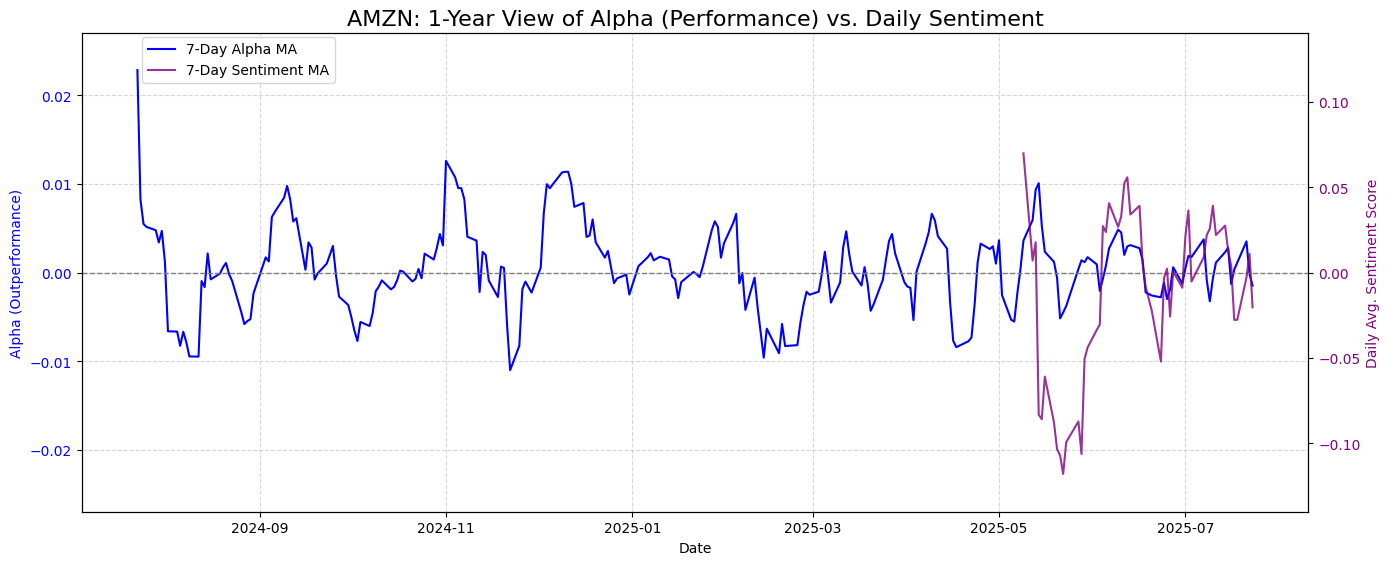

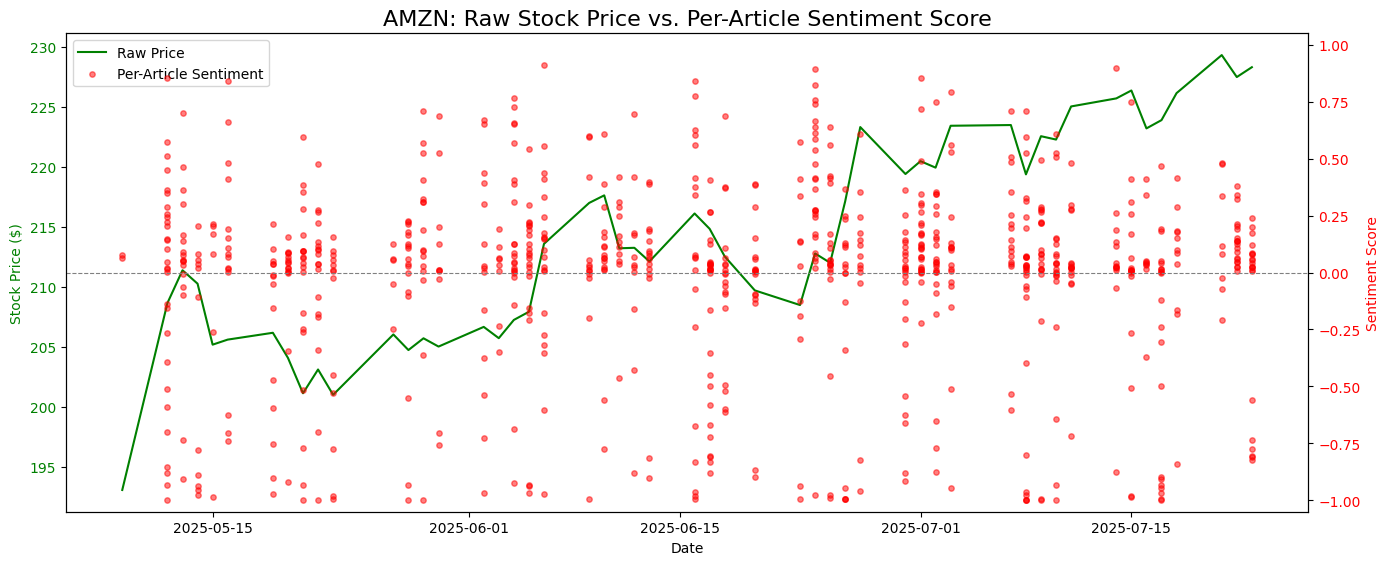

In [18]:
# ─── Cell 4: Plotting with Raw Per-Article Data ───────────────────────────────
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ─── CONFIG ───────────────────────────────────────────────────────────────────
SENT_DIR  = Path("sentiment_scores")
PRICE_DIR = Path("stock_price")
CAPM_DIR  = Path("CAPM")
ROLLING_AVG = 7

# ─── USER INPUT ───────────────────────────────────────────────────────────────
tickers_input = input("Enter tickers (e.g. AAPL,MSFT) or 'ALL' for all from CAPM folder: ")
if tickers_input.strip().upper() == 'ALL':
    TICKERS = [p.stem.replace("_CAPM", "") for p in CAPM_DIR.glob("*.csv")]
    print(f"Found all available tickers: {TICKERS}")
else:
    TICKERS = [t.strip().upper() for t in tickers_input.split(",") if t.strip()]

if not TICKERS:
    raise ValueError("No tickers specified.")

# ─── GENERATE PLOTS ───────────────────────────────────────────────────────────
for ticker in TICKERS:
    try:
        # Data for Plot 1 (Alpha vs Daily Sentiment)
        daily_sent_df = pd.read_csv(SENT_DIR/f"{ticker}_daily_scores.csv", parse_dates=["date"])
        capm_df  = pd.read_csv(CAPM_DIR/f"{ticker}_CAPM.csv", parse_dates=["date"])
        
        # Data for Plot 2 (Raw Price vs Per-Article Sentiment)
        article_sent_df = pd.read_csv(SENT_DIR/f"{ticker}_article_scores.csv", parse_dates=["date"])
        price_df = pd.read_csv(PRICE_DIR/f"{ticker}_price.csv", parse_dates=["date"])

    except FileNotFoundError as e:
        print(f"Could not find a required file for {ticker}: {e}. Skipping plots.")
        continue

    print(f"\n--- Generating plots for {ticker} ---")

    # ─── PLOT 1: ALPHA vs DAILY SENTIMENT (Unchanged) ─────────────────────────
    # Merge data for the first plot
    df1 = pd.merge(price_df, daily_sent_df, on="date", how="left")
    df1 = pd.merge(df1, capm_df, on="date", how="left")

    if not df1.empty:
        df1 = df1.sort_values('date')
        last_date = df1['date'].max()
        one_year_ago = last_date - pd.DateOffset(years=1)
        df1 = df1[df1['date'] >= one_year_ago].copy()

    df1.set_index('date', inplace=True)
    df1[['sentiment', 'alpha']] = df1[['sentiment', 'alpha']].fillna(method='ffill')
    df1.reset_index(inplace=True)
    df1.dropna(subset=['close'], inplace=True)
    df1["sentiment_ma"] = df1["sentiment"].rolling(ROLLING_AVG, min_periods=1).mean()
    df1["alpha_ma"] = df1["alpha"].rolling(ROLLING_AVG, min_periods=1).mean()

    fig, ax1 = plt.subplots(figsize=(14, 6))
    plt.title(f"{ticker}: 1-Year View of Alpha (Performance) vs. Daily Sentiment", fontsize=16)
    ax1.plot(df1["date"], df1["alpha_ma"], color="blue", label=f"{ROLLING_AVG}-Day Alpha MA")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Alpha (Outperformance)", color="blue")
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid(True, linestyle="--", alpha=0.5)
    ax1.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax2 = ax1.twinx()
    ax2.plot(df1["date"], df1["sentiment_ma"], color="purple", label=f"{ROLLING_AVG}-Day Sentiment MA", alpha=0.8)
    ax2.set_ylabel("Daily Avg. Sentiment Score", color="purple")
    ax2.tick_params(axis='y', labelcolor='purple')
    y1_min, y1_max = ax1.get_ylim(); y1_abs_max = max(abs(y1_min), abs(y1_max)) * 1.1; ax1.set_ylim(-y1_abs_max, y1_abs_max)
    y2_min, y2_max = ax2.get_ylim(); y2_abs_max = max(abs(y2_min), abs(y2_max)) * 1.1; ax2.set_ylim(-y2_abs_max, y2_abs_max)
    fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9)); plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()

    # ─── PLOT 2: RAW PRICE vs PER-ARTICLE SENTIMENT (New Logic) ───────────────
    # Merge per-article sentiment with price data. This automatically sets the date range.
    df2 = pd.merge(article_sent_df, price_df, on="date", how="left").dropna()

    if df2.empty:
        print(f"No matching data found for per-article plot for {ticker}. Skipping.")
        continue

    fig, ax1 = plt.subplots(figsize=(14, 6))
    plt.title(f"{ticker}: Raw Stock Price vs. Per-Article Sentiment Score", fontsize=16)

    # Plot 1: Raw Price
    ax1.plot(df2["date"], df2["close"], color="green", label="Raw Price")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Stock Price ($)", color="green")
    ax1.tick_params(axis='y', labelcolor='green')
    
    # Plot 2: Per-Article Sentiment as a scatter plot
    ax2 = ax1.twinx()
    # Use a scatter plot because there can be multiple articles (and scores) per day
    ax2.scatter(df2["date"], df2["sentiment"], color="red", label="Per-Article Sentiment", alpha=0.5, s=15) # s is marker size
    ax2.set_ylabel("Sentiment Score", color="red")
    ax2.tick_params(axis='y', labelcolor='red')
    # Set sentiment limits from -1 to 1, which is the natural range of the score
    ax2.set_ylim(-1.05, 1.05)
    ax2.axhline(0, color="gray", linestyle="--", linewidth=0.8)
    
    # Create a combined legend
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, loc="upper left")
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()